In [1]:
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm 
from torchvision.transforms import ToTensor
import torch.nn.init as init


2024-03-20 12:55:08.218818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 12:55:08.218957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 12:55:08.340165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


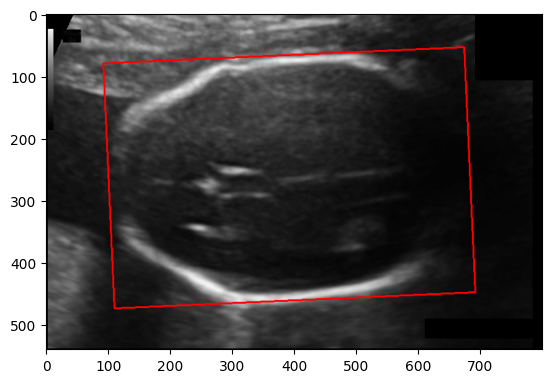

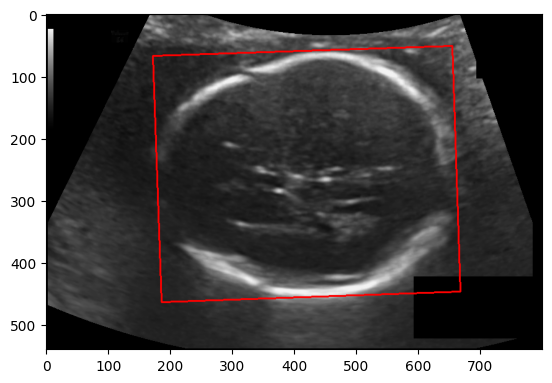

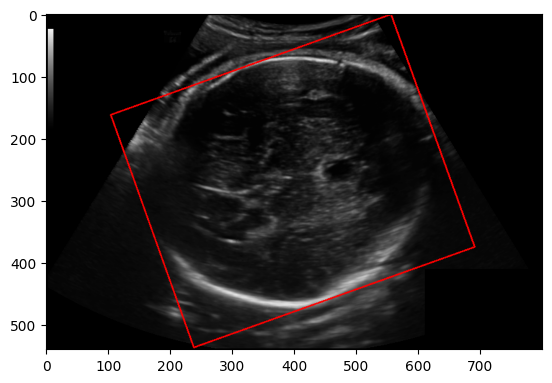

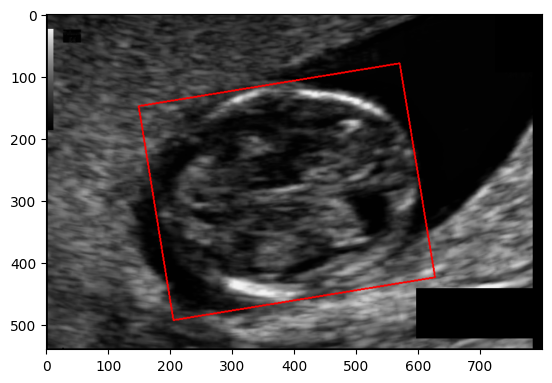

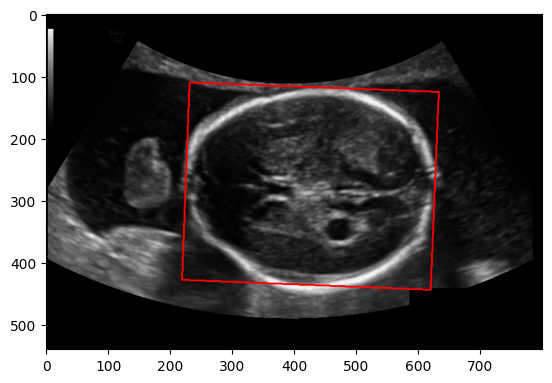

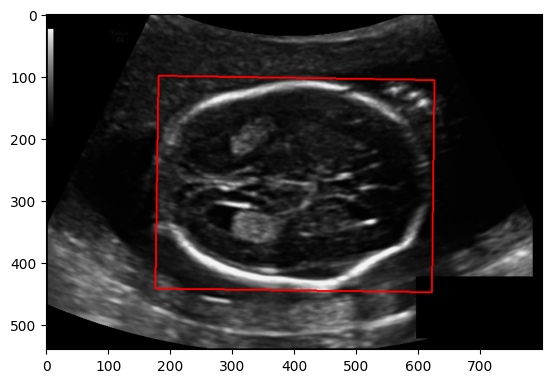

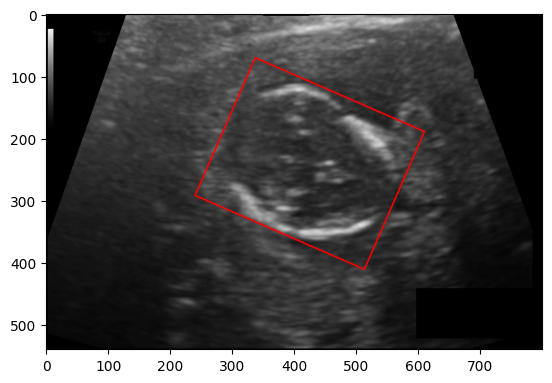

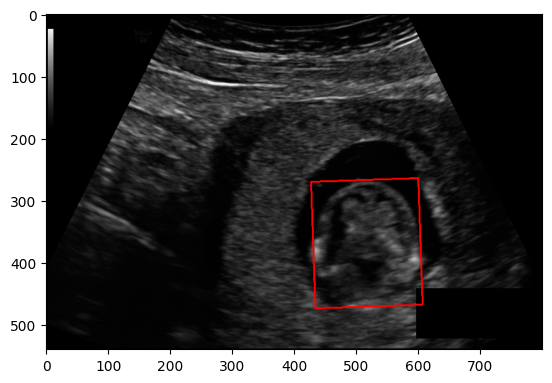

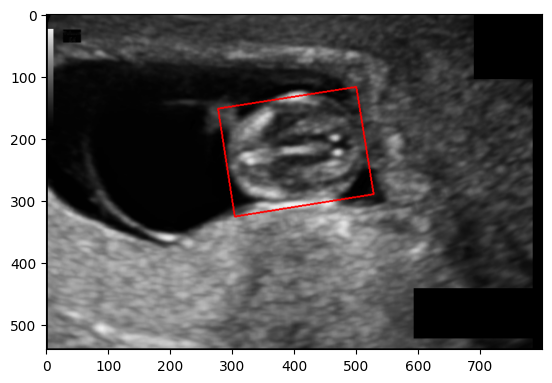

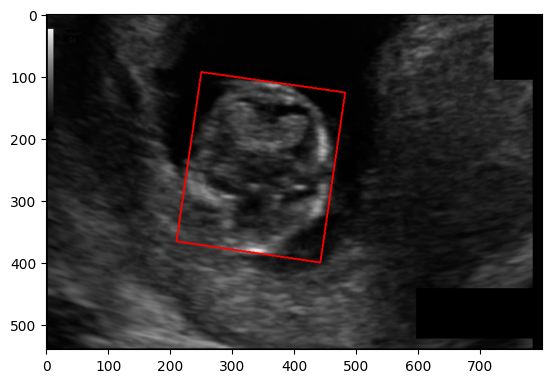

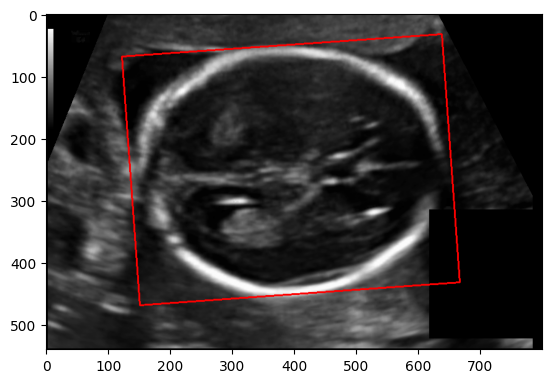

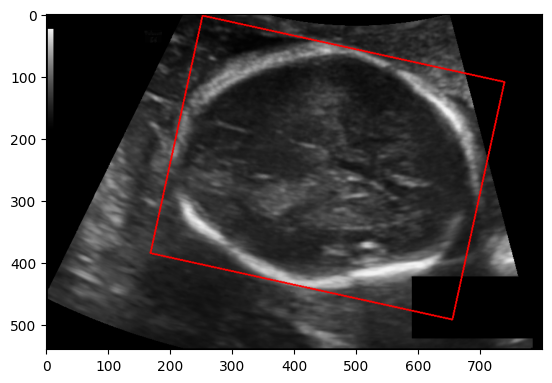

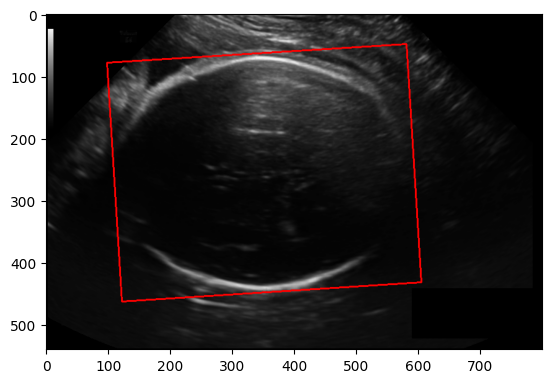

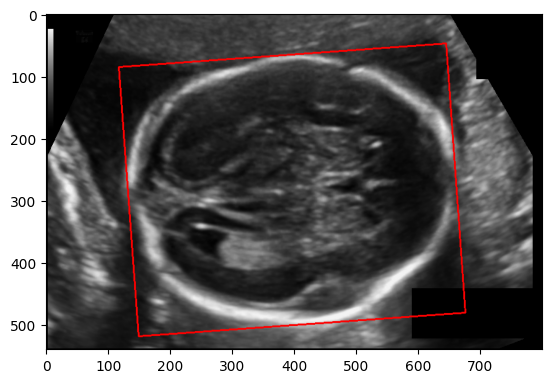

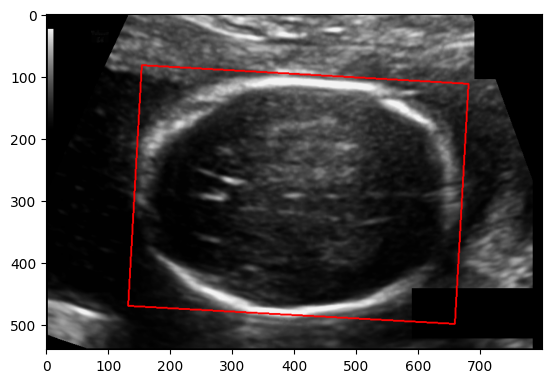

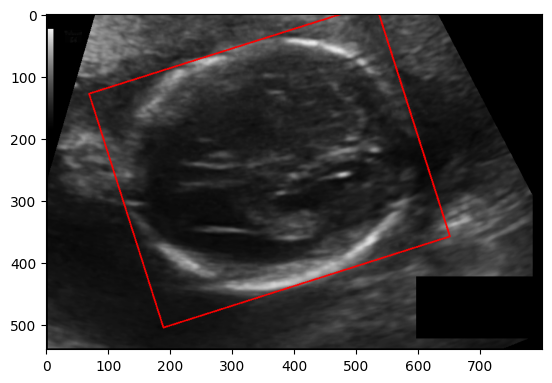

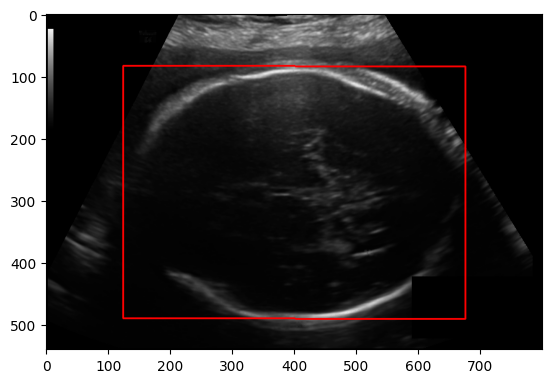

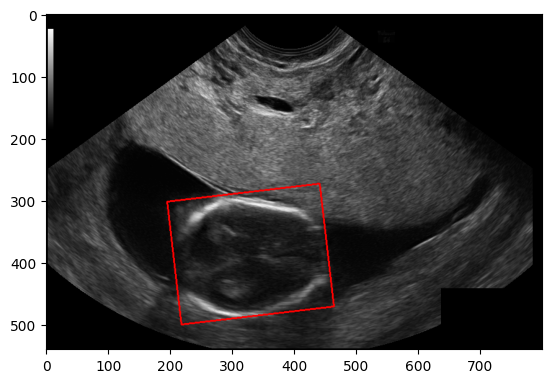

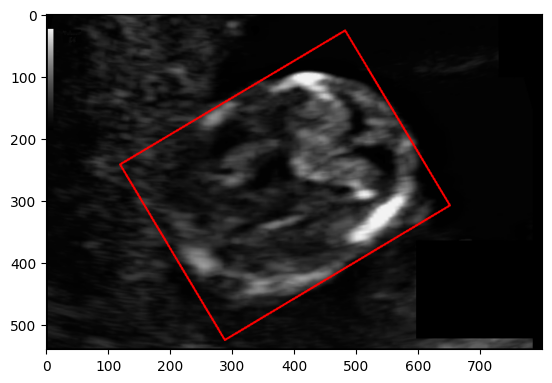

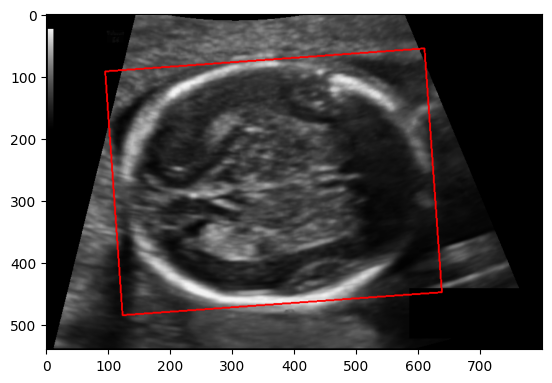

In [2]:
def get_bounding_box(filename):
  try:
    with open(filename, "r") as f:
      data = f.readline().strip().split(" ")
    return [float(x) for x in data[1:]]  
  except:
    return None

def visualize_bounding_box(image_path, bbox):
    img = cv2.imread(image_path)
    x1, y1, x2, y2, x3, y3, x4, y4 = bbox
    x1, y1, x2, y2, x3, y3, x4, y4 = int(x1 * img.shape[1]), int(y1 * img.shape[0]), int(x2 * img.shape[1]), int(y2 * img.shape[0]), int(x3 * img.shape[1]), int(y3 * img.shape[0]), int(x4 * img.shape[1]), int(y4 * img.shape[0])

    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.line(img, (x2, y2), (x3, y3), (255, 0, 0), 2)
    cv2.line(img, (x3, y3), (x4, y4), (255, 0, 0), 2)
    cv2.line(img, (x4, y4), (x1, y1), (255, 0, 0), 2)

    plt.imshow(img)
    plt.show()
images_directory = "/kaggle/input/fetal-head-circumference/data/train/images"
imgs = [filename.split(".")[0] for filename in os.listdir(images_directory)]
for i in range(20):
    bounding_box = get_bounding_box(f"/kaggle/input/fetal-head-circumference/data/train/labels/{imgs[i]}.txt")
    visualize_bounding_box(f"/kaggle/input/fetal-head-circumference/data/train/images/{imgs[i]}.png", bounding_box)



In [3]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inblock1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=(96, 94)),  
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )
        self.inblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU()
        )
        self.inblock3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(),
        )
        self.inblock4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
        )

        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 1024, 3),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 2, 2)
        )

        self.outblock4 = nn.Sequential(
            nn.Conv2d(1024, 512, 3),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 2, 2)
        )
        self.outblock3 = nn.Sequential(
            nn.Conv2d(512, 256, 3),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, 2)
        )
        self.outblock2 = nn.Sequential(
            nn.Conv2d(256, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, 2)
        )
        self.outblock1 = nn.Sequential(
            nn.Conv2d(128, 9, 3),  
            nn.ReLU(),
            nn.Conv2d(9, 9, 3),
            nn.ReLU(),
            nn.Conv2d(9, 9, 1),
            nn.Sigmoid()
        )

    def forward(self, data):
        in1 = self.inblock1(data)
        in2 = self.inblock2(in1)
        in3 = self.inblock3(in2)
        in4 = self.inblock4(in3)

        out4 = self.bottleneck(in4)
        x4, y4 = out4.shape[-2], out4.shape[-1]
        out4 = torch.cat([in4[:, :, in4.shape[-2]//2-x4//2:in4.shape[-2]//2-x4//2+x4, in4.shape[-1]//2-y4//2:in4.shape[-1]//2-y4//2+y4], out4], dim=1)

        out3 = self.outblock4(out4)
        x3, y3 = out3.shape[-2], out3.shape[-1]
        out3 = torch.cat([in3[:, :, in3.shape[-2]//2-x3//2:in3.shape[-2]//2-x3//2+x3, in3.shape[-1]//2-y3//2:in3.shape[-1]//2-y3//2+y3], out3], dim=1)

        out2 = self.outblock3(out3)
        x2, y2 = out2.shape[-2], out2.shape[-1]
        out2 = torch.cat([in2[:, :, in2.shape[-2]//2-x2//2:in2.shape[-2]//2-x2//2+x2, in2.shape[-1]//2-y2//2:in2.shape[-1]//2-y2//2+y2], out2], dim=1)

        out1 = self.outblock2(out2)
        x1, y1 = out1.shape[-2], out1.shape[-1]
        out1 = torch.cat([in1[:, :, in1.shape[-2]//2-x1//2:in1.shape[-2]//2-x1//2+x1, in1.shape[-1]//2-y1//2:in1.shape[-1]//2-y1//2+y1], out1], dim=1)

        output = self.outblock1(out1)
        return output

In [4]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_height, img_width):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.img_height = img_height
        self.img_width = img_width
        self.image_filenames = [filename for filename in os.listdir(images_dir) if filename.endswith('_HC.png')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        label_filename = image_filename.replace('_HC.png', '_HC.txt')
        label_path = os.path.join(self.labels_dir, label_filename)

        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.img_width, self.img_height))
        image = image / 255.0  

        with open(label_path, 'r') as file:
            label_str = file.read().strip() 
            label_list = [float(num) for num in label_str.split()]  
            label = torch.tensor(label_list, dtype=torch.float32)  

        return image, label
train_images_dir = "/kaggle/input/fetal-head-circumference/data/train/images"
train_labels_dir = "/kaggle/input/fetal-head-circumference/data/train/labels"
val_images_dir = "/kaggle/input/fetal-head-circumference/data/val/images"
val_labels_dir = "/kaggle/input/fetal-head-circumference/data/val/labels"
test_images_dir = "/kaggle/input/fetal-head-circumference/data/test/images"
test_labels_dir = "/kaggle/input/fetal-head-circumference/data/test/labels"
img_height = 540
img_width = 800
train_dataset = CustomDataset(train_images_dir, train_labels_dir, img_height, img_width)
val_dataset = CustomDataset(val_images_dir, val_labels_dir, img_height, img_width)
test_dataset = CustomDataset(test_images_dir, test_labels_dir, img_height, img_width)
train_dataset = [(image, label) for image, label in train_dataset if image is not None and label is not None]

In [13]:
def compute_iou(pred, target):
    intersection = torch.logical_and(pred, target).sum()
    union = torch.logical_or(pred, target).sum()
    iou = intersection / union
    return iou.item()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_iou = 0.0
    pbar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch [{epoch+1}/{num_epochs}]')
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        images_gray = torch.mean(images, dim=1, keepdim=True).to(torch.float32)
        optimizer.zero_grad()
        outputs = model(images_gray)  
        labels = labels.unsqueeze(2).unsqueeze(3)  
        outputs = outputs[:, :, :labels.size(-2), :labels.size(-1)]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_train.append(running_loss/len(train_loader))
        predictions = (outputs > 0.5).float()  
        iou = compute_iou(predictions, labels)
        total_iou += iou

    print(f'MSE Loss: {loss.item()}, IoU: {total_iou/len(train_loader)}')
    val_loss = validate(model, val_loader, criterion, device)
    validate_loss.append(val_loss / len(val_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}')
print("Training completed.")


Epoch [1/10]: 100%|██████████| 70/70 [00:21<00:00,  3.26it/s]


MSE Loss: 0.11045089364051819, IoU: 0.3142857142857143
Epoch [1/10], Loss: 0.10714560917445591, Validation Loss: 0.0050052530438451275


Epoch [2/10]: 100%|██████████| 70/70 [00:21<00:00,  3.26it/s]


MSE Loss: 0.09593847393989563, IoU: 0.3678571428571429
Epoch [2/10], Loss: 0.10608227061373847, Validation Loss: 0.004967519941648929


Epoch [3/10]: 100%|██████████| 70/70 [00:21<00:00,  3.27it/s]


MSE Loss: 0.1458061784505844, IoU: 0.375
Epoch [3/10], Loss: 0.10586215555667877, Validation Loss: 0.004931173525970269


Epoch [4/10]: 100%|██████████| 70/70 [00:21<00:00,  3.27it/s]


MSE Loss: 0.13757409155368805, IoU: 0.375
Epoch [4/10], Loss: 0.10492513435227531, Validation Loss: 0.004891161627374809


Epoch [5/10]: 100%|██████████| 70/70 [00:21<00:00,  3.27it/s]


MSE Loss: 0.13267433643341064, IoU: 0.375
Epoch [5/10], Loss: 0.10419058884893145, Validation Loss: 0.004850381153240766


Epoch [6/10]: 100%|██████████| 70/70 [00:21<00:00,  3.27it/s]


MSE Loss: 0.1032591462135315, IoU: 0.375
Epoch [6/10], Loss: 0.10296382350581033, Validation Loss: 0.00481305266318678


Epoch [7/10]: 100%|██████████| 70/70 [00:21<00:00,  3.27it/s]


MSE Loss: 0.14202871918678284, IoU: 0.375
Epoch [7/10], Loss: 0.10272178085786955, Validation Loss: 0.004786334948745174


Epoch [8/10]: 100%|██████████| 70/70 [00:21<00:00,  3.27it/s]


MSE Loss: 0.08861113339662552, IoU: 0.375
Epoch [8/10], Loss: 0.10138446284191949, Validation Loss: 0.004744423287255424


Epoch [9/10]: 100%|██████████| 70/70 [00:21<00:00,  3.26it/s]


MSE Loss: 0.060571540147066116, IoU: 0.375
Epoch [9/10], Loss: 0.10027460333492075, Validation Loss: 0.0047191856027730735


Epoch [10/10]: 100%|██████████| 70/70 [00:21<00:00,  3.29it/s]


MSE Loss: 0.03212656080722809, IoU: 0.5
Epoch [10/10], Loss: 0.09928166259612356, Validation Loss: 0.004678746503767243
Training completed.
